# Payment Amount Prediction (Collections)

This demo notebook shows how to predict **payment amount collected** using a clean, production-friendly approach:

- **Synthetic dataset** (no real customer data, company identifiers, or infrastructure details)
- Tabular features mimicking a realistic setup: **transactions**, **collector actions**, and **customer profile**
- Model: **CatBoostRegressor** wrapped in an **sklearn Pipeline**
- Evaluation in **log-space** and visual diagnostics: **Actual vs Predicted**, **error distribution**, **residuals**

> Note: The target is modeled in log-space to handle heavy-tailed amounts (common for payment data).

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

## 1) Generate a synthetic dataset

We create a dataset that resembles a collections domain:

- **Customer profile**: age bucket, employment type, region
- **Transactions**: prior payments count, last payment recency, average payment size
- **Collector actions**: number of calls, messages, visits, promise-to-pay flags

The amount is generated with **non-linear effects** and **noise** to produce a realistic scatter in log-space.

In [2]:
rng = np.random.default_rng(42)

N = 20000

# Categorical-like features (kept generic)
region = rng.choice(["region_a", "region_b", "region_c", "region_d", "region_e"], size=N, p=[0.25,0.2,0.2,0.2,0.15])
employment = rng.choice(["salaried", "self_employed", "unemployed", "student"], size=N, p=[0.55,0.25,0.15,0.05])
channel = rng.choice(["sms", "call", "whatsapp", "email"], size=N, p=[0.25,0.45,0.25,0.05])

# Numeric features
age = rng.integers(18, 65, size=N)
tenure_months = rng.integers(0, 84, size=N)
prior_payments_cnt = rng.poisson(lam=2.0, size=N)
days_since_last_payment = rng.integers(0, 365, size=N)

calls_cnt_7d = rng.poisson(lam=1.8, size=N)
messages_cnt_7d = rng.poisson(lam=2.2, size=N)
visits_cnt_30d = rng.poisson(lam=0.12, size=N)

promise_to_pay = rng.binomial(1, 0.18, size=N)
broken_promises_cnt = rng.poisson(lam=0.4, size=N)

# Some "exposure" like outstanding balance (generic)
outstanding_balance = np.exp(rng.normal(loc=10.5, scale=0.55, size=N))  # heavy-tailed

# Non-linear signal in log-space (generic, no proprietary coefficients)
emp_effect = np.select(
    [employment=="salaried", 
     employment=="self_employed", 
     employment=="unemployed", 
     employment=="student"],
    [0.25, 0.18, -0.25, -0.05],
    default=0.0
)
region_effect = np.select(
    [region=="region_a", region=="region_b", region=="region_c", region=="region_d", region=="region_e"],
    [0.10, 0.05, 0.0, -0.03, -0.07],
    default=0.0
)

contact_intensity = 0.12*np.log1p(calls_cnt_7d) + 0.08*np.log1p(messages_cnt_7d) + 0.15*np.log1p(visits_cnt_30d)
promise_effect = 0.22*promise_to_pay - 0.10*np.log1p(broken_promises_cnt)

recency_penalty = -0.10*np.log1p(days_since_last_payment)
history_bonus = 0.08*np.log1p(prior_payments_cnt)

balance_term = 0.35*np.log1p(outstanding_balance)

# Base log-amount
log_amount = (
    6.8
    + 0.015*age
    + 0.010*tenure_months
    + balance_term
    + emp_effect
    + region_effect
    + contact_intensity
    + promise_effect
    + recency_penalty
    + history_bonus
)

# Add heteroscedastic noise (more spread for high balances)
noise = rng.normal(loc=0.0, scale=0.35 + 0.07*np.log1p(outstanding_balance)/10.0, size=N)
log_amount_noisy = log_amount + noise

# Convert to positive amount in currency units
amount = np.expm1(log_amount_noisy)  # inverse of log1p

df = pd.DataFrame({
    "age": age,
    "tenure_months": tenure_months,
    "prior_payments_cnt": prior_payments_cnt,
    "days_since_last_payment": days_since_last_payment,
    "calls_cnt_7d": calls_cnt_7d,
    "messages_cnt_7d": messages_cnt_7d,
    "visits_cnt_30d": visits_cnt_30d,
    "promise_to_pay": promise_to_pay,
    "broken_promises_cnt": broken_promises_cnt,
    "outstanding_balance": outstanding_balance,
    "region": region,
    "employment": employment,
    "preferred_channel": channel,
    "amount": amount
})

# Inject a small amount of missingness
for col in ["region", "employment", "preferred_channel"]:
    mask = rng.random(N) < 0.01
    df.loc[mask, col] = None

for col in ["outstanding_balance", "days_since_last_payment"]:
    mask = rng.random(N) < 0.01
    df.loc[mask, col] = np.nan

df.head()

,age,tenure_months,prior_payments_cnt,days_since_last_payment,calls_cnt_7d,messages_cnt_7d,visits_cnt_30d,promise_to_pay,broken_promises_cnt,outstanding_balance,region,employment,preferred_channel,amount
0,18,40,1,216.0,1,2,0,0,0,28589.290604,region_d,self_employed,call,29525.099161
1,56,18,4,60.0,0,4,0,0,2,14665.698815,region_b,student,sms,49355.746325
2,23,76,1,24.0,2,1,0,1,0,27455.808629,region_e,salaried,sms,146218.682186
3,52,19,1,364.0,5,3,0,0,0,30944.719159,region_d,salaried,sms,51939.107115
4,18,10,3,279.0,1,5,1,1,1,55493.559477,region_a,self_employed,email,99296.513976


## 2) Train/Test split and target transformation

We model the target in **log-space**:

- `y = log1p(amount)`

This stabilizes variance and improves learning for heavy-tailed amounts.

In [3]:
target_col = "amount"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].copy()
y = np.log1p(df[target_col].values)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape

((15000, 13), (5000, 13))

## 3) Production-style pipeline (CatBoost)

Key points:
- Keep preprocessing deterministic and explicit.
- Use CatBoost native categorical handling.
- Pipeline can be exported / reused in batch or online inference.

In [4]:
cat_features = ["region", "employment", "preferred_channel"]

num_features = [c for c in feature_cols if c not in cat_features]

# Preprocess numeric - missing with median
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# Preprocess categorical -  missing with a constant and cast to string
def _to_str_frame(X):
    X = pd.DataFrame(X).copy()
    return X.astype("string").fillna("missing").astype(str)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("to_str", FunctionTransformer(_to_str_frame, feature_names_out="one-to-one")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

cat_feature_indices = list(range(len(num_features), len(num_features) + len(cat_features)))


# CatBoost config
cb = CatBoostRegressor(
    loss_function="RMSE",
    iterations=1200,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=6.0,
    random_seed=42,
    verbose=False,
    cat_features=cat_feature_indices
)

# Final pipeline
model = Pipeline(steps=[
    ("prep", preprocess),
    ("cb", cb),
])

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'tenure_months',
                                                   'prior_payments_cnt',
                                                   'days_since_last_payment',
                                                   'calls_cnt_7d',
                                                   'messages_cnt_7d',
                                                   'visits_cnt_30d',
                                                   'promise_to_pay',
                                                   'broken_promises_cnt',
                                                   'outstanding_balance']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('to_str',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function _to_str_frame at 0x70a9468cc820>))]),
                                                  ['region', 'employment',
                                                   'preferred_channel'])],
                                   verbose_feature_names_out=False)),
                ('cb',
                 <catboost.core.CatBoostRegressor object at 0x70a947668280>)])

### Fit
We pass `cat_features` indices to CatBoost by providing preprocessed data with categorical columns as strings.

In this pipeline, the `ColumnTransformer` outputs a numpy array. To keep CatBoost aware of categorical columns, we feed CatBoost with **string columns already in the array**.

CatBoost can infer categorical columns if they are strings; in practice this works well for demos and many production settings.

> If your production environment requires strict `cat_features` indices, you can also wrap CatBoost with a custom estimator that builds `Pool` explicitly.

In [5]:
# Fit the pipeline
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metrics in log-space
def metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return pd.Series({"MAE": mae, "RMSE": rmse, "R2": r2}, name=name)

pd.concat([
    metrics(y_train, y_pred_train, "Train (log)"),
    metrics(y_test, y_pred_test, "Test (log)")
], axis=1)

,Train (log),Test (log)
MAE,0.284084,0.350809
RMSE,0.358901,0.436635
R2,0.652532,0.491083


## 4) Visual diagnostics
### 4.1 Actual vs Predicted (Train/Test)
We replicate the classic plot: two panels, blue scatter, and the red dashed `y=x` line.

- X axis: **Actual (log scale)**
- Y axis: **Predicted (log scale)**

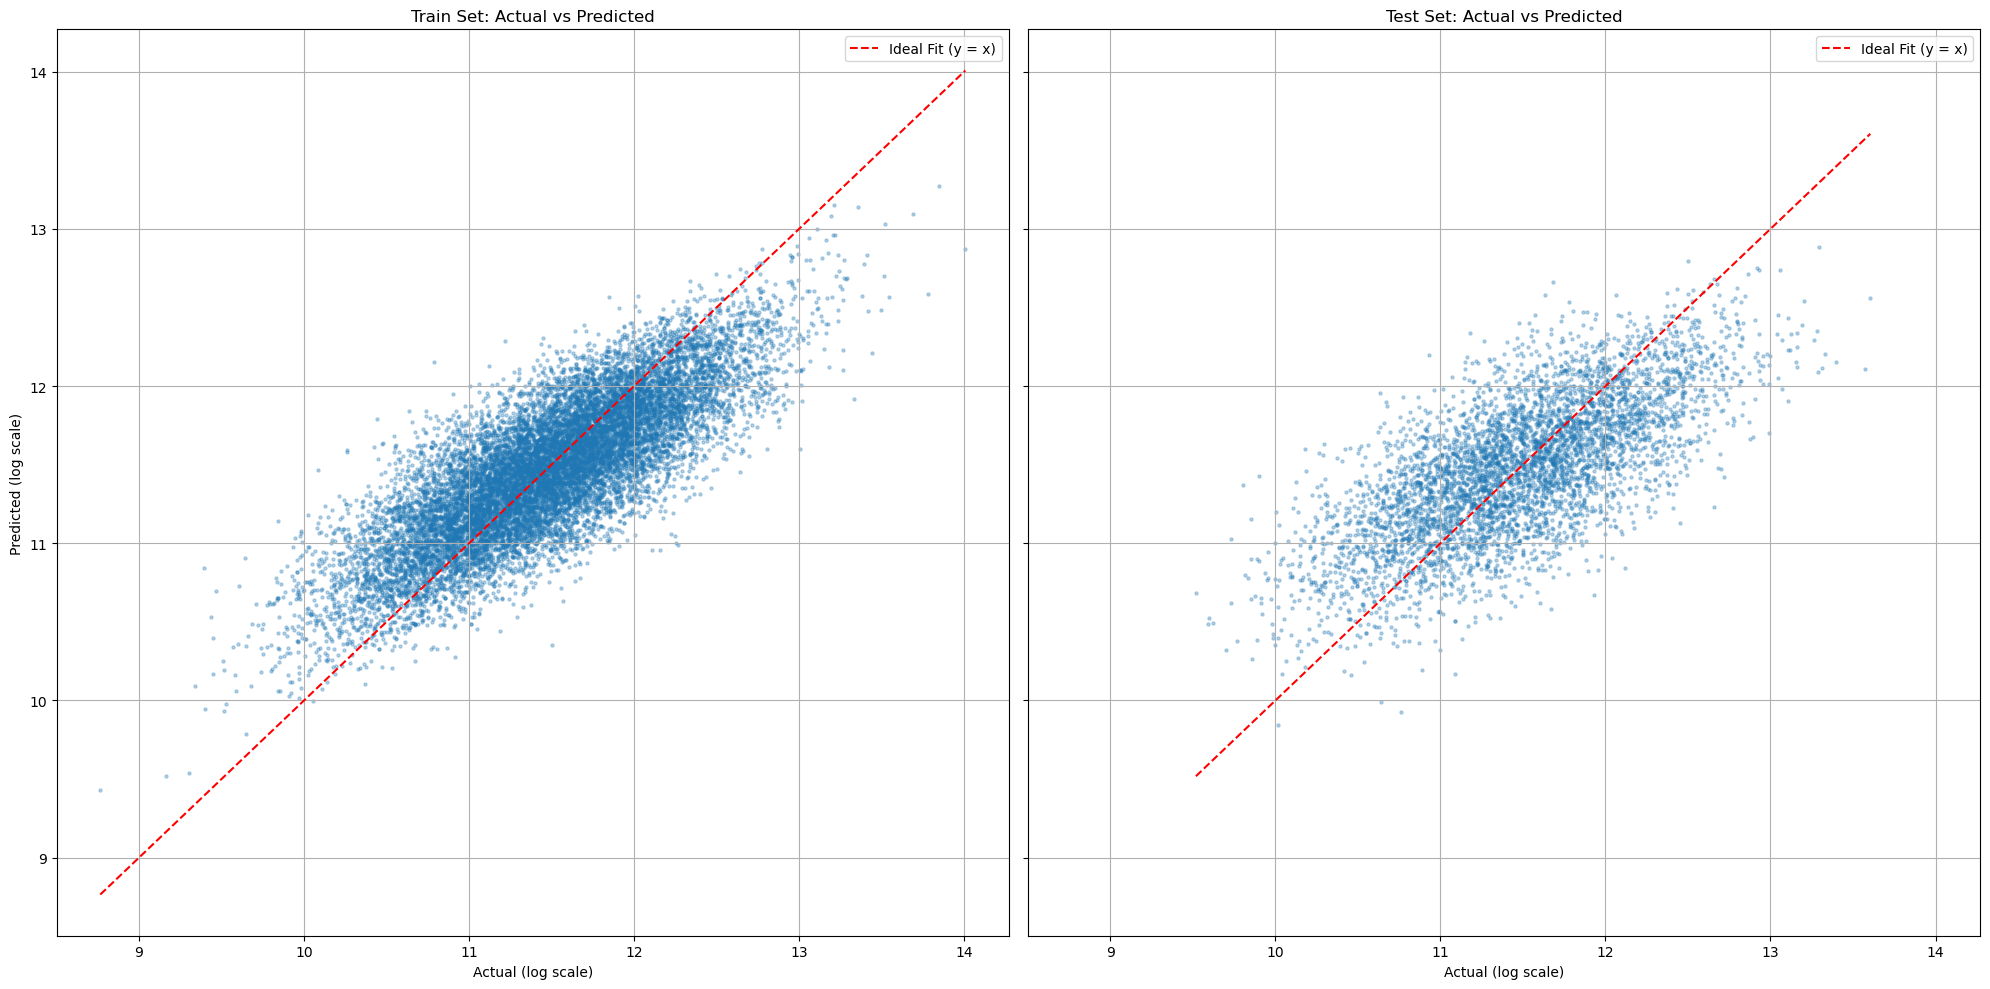

In [6]:
# Match the visual style closely
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# Train
axes[0].scatter(y_train, y_pred_train, alpha=0.3, s=5)
min_v = min(y_train.min(), y_pred_train.min())
max_v = max(y_train.max(), y_pred_train.max())
axes[0].plot([min_v, max_v], [min_v, max_v], 'r--', label="Ideal Fit (y = x)")
axes[0].set_title("Train Set: Actual vs Predicted")
axes[0].set_xlabel("Actual (log scale)")
axes[0].set_ylabel("Predicted (log scale)")
axes[0].grid(True)
axes[0].legend()

# Test
axes[1].scatter(y_test, y_pred_test, alpha=0.3, s=5)
min_v2 = min(y_test.min(), y_pred_test.min())
max_v2 = max(y_test.max(), y_pred_test.max())
axes[1].plot([min_v2, max_v2], [min_v2, max_v2], 'r--', label="Ideal Fit (y = x)")
axes[1].set_title("Test Set: Actual vs Predicted")
axes[1].set_xlabel("Actual (log scale)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

### 4.2 Error distribution (Train vs Test)
We plot distributions of `(pred - actual)` in log-space.

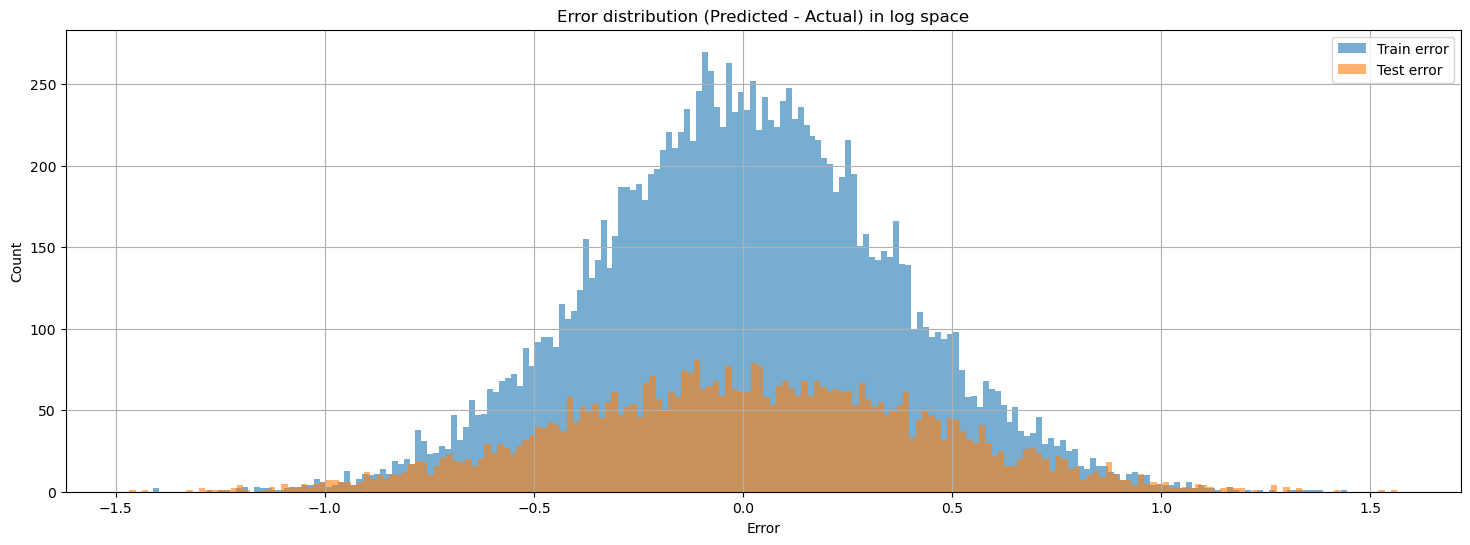

In [7]:
err_train = y_pred_train - y_train
err_test = y_pred_test - y_test

plt.figure(figsize=(18, 6))
plt.hist(err_train, bins=200, alpha=0.6, label="Train error")
plt.hist(err_test, bins=200, alpha=0.6, label="Test error")
plt.title("Error distribution (Predicted - Actual) in log space")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.show()

### 4.3 Residuals diagnostics
Residuals should be centered around 0 and ideally show no strong pattern vs predictions.

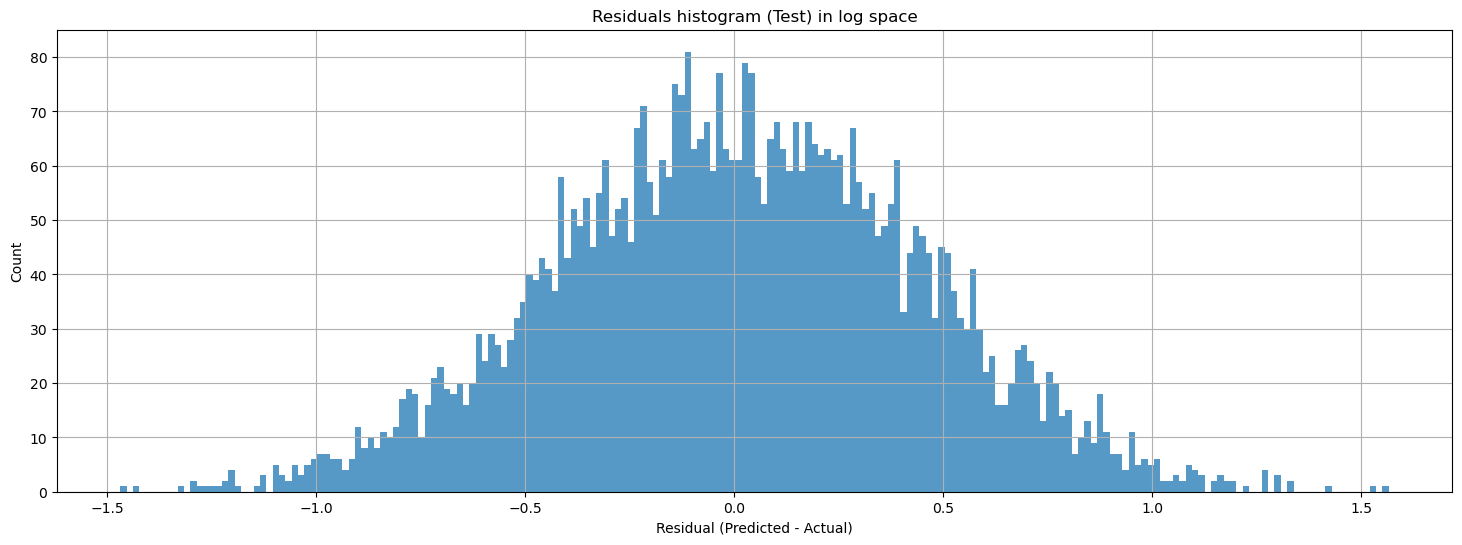

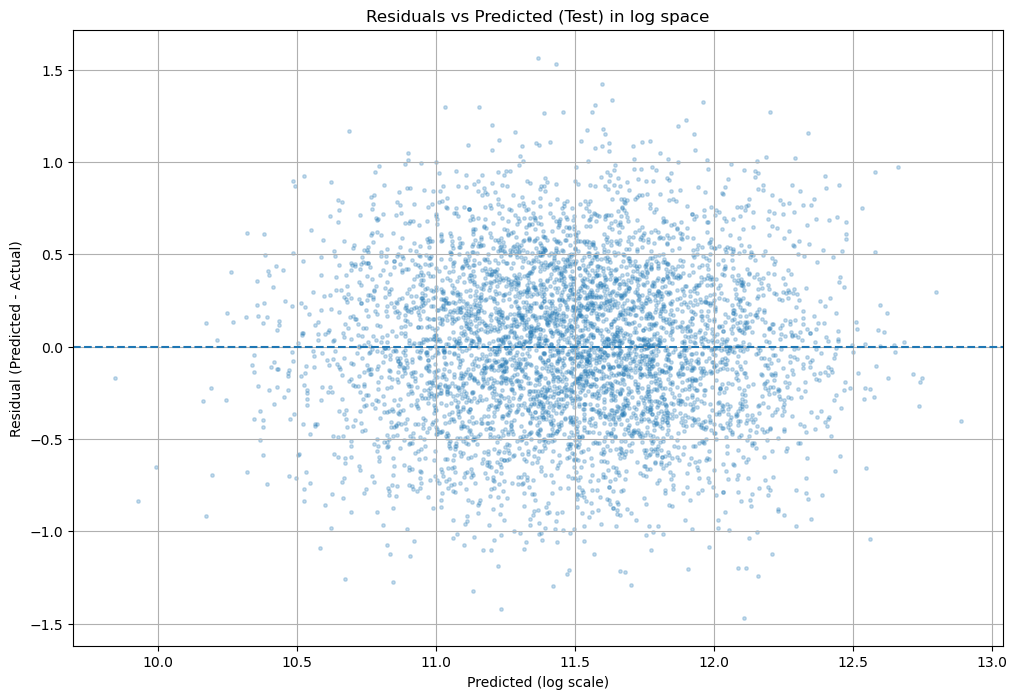

In [8]:
# Residuals histogram (OLS-style)
plt.figure(figsize=(18, 6))
plt.hist(err_test, bins=200, alpha=0.75)
plt.title("Residuals histogram (Test) in log space")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_pred_test, err_test, alpha=0.25, s=6)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted (Test) in log space")
plt.xlabel("Predicted (log scale)")
plt.ylabel("Residual (Predicted - Actual)")
plt.grid(True)
plt.show()

## 5) Optional: Convert predictions back to amount space
Metrics in currency space are often intuitive for business, but optimization is typically done in log-space.

In [9]:
# Back-transform (approximate)
amount_true_test = np.expm1(y_test)
amount_pred_test = np.expm1(y_pred_test)

mae_amount = mean_absolute_error(amount_true_test, amount_pred_test)
rmse_amount = mean_squared_error(amount_true_test, amount_pred_test, squared=False)

pd.DataFrame({
    "MAE_amount": [mae_amount],
    "RMSE_amount": [rmse_amount]
})

,MAE_amount,RMSE_amount
0,38911.042509,57839.33236


## 6) Notes for productionization
- Keep the full `Pipeline` object for consistent preprocessing.
- Export with `joblib.dump(pipeline, ...)`.
- For strict categorical handling, consider building `catboost.Pool` in a custom wrapper estimator.
- Monitor drift and stability: feature distributions + residuals over time.

In [10]:
import joblib, os

# save pipeline artifact
os.makedirs("artifacts", exist_ok=True)
joblib.dump(model, "artifacts/catboost_amount_pipeline.joblib")
"Saved to artifacts/catboost_amount_pipeline.joblib" 

'Saved to artifacts/catboost_amount_pipeline.joblib'